Iteration 1/10 completed.
Iteration 1/10 completed. Best Fitness: 0.0510
Iteration 2/10 completed.
Iteration 2/10 completed. Best Fitness: 0.0510
Iteration 3/10 completed.
Iteration 3/10 completed. Best Fitness: 0.0369
Iteration 4/10 completed.
Iteration 4/10 completed. Best Fitness: 0.0369
Iteration 5/10 completed.
Iteration 5/10 completed. Best Fitness: 0.0369
Iteration 6/10 completed.
Iteration 6/10 completed. Best Fitness: 0.0369
Iteration 7/10 completed.
Iteration 7/10 completed. Best Fitness: 0.0369
Iteration 8/10 completed.
Iteration 8/10 completed. Best Fitness: 0.0351
Iteration 9/10 completed.
Iteration 9/10 completed. Best Fitness: 0.0351
Iteration 10/10 completed.
Iteration 10/10 completed. Best Fitness: 0.0351
Iteration 1/10 completed.
Iteration 1/10 completed. Best Fitness: 0.0475
Iteration 2/10 completed.
Iteration 2/10 completed. Best Fitness: 0.0404
Iteration 3/10 completed.
Iteration 3/10 completed. Best Fitness: 0.0404
Iteration 4/10 completed.
Iteration 4/10 complete

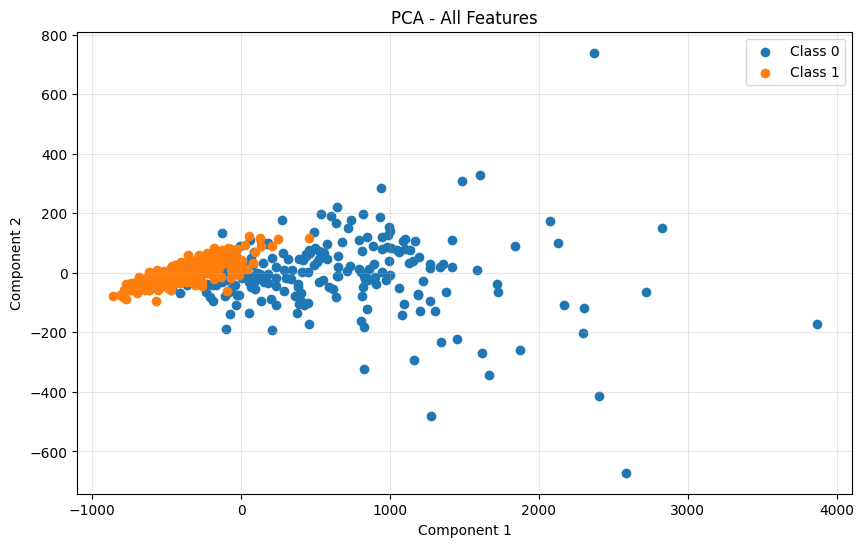

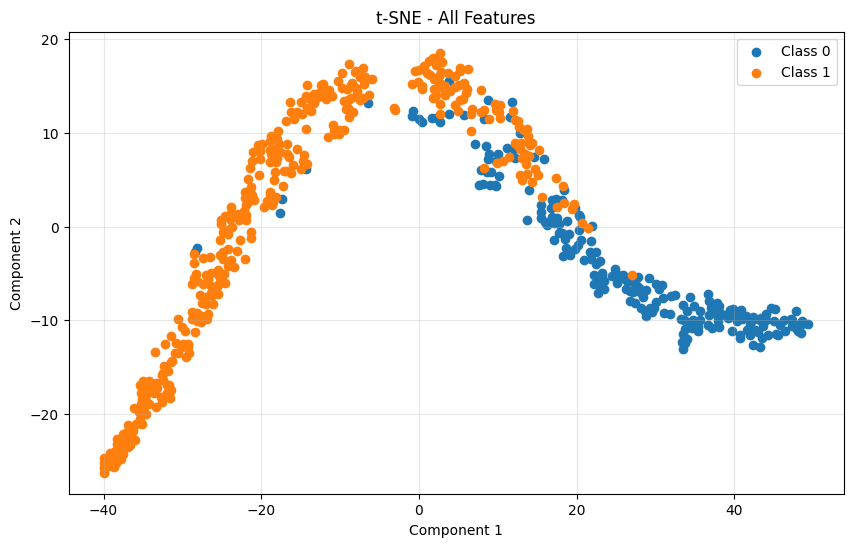

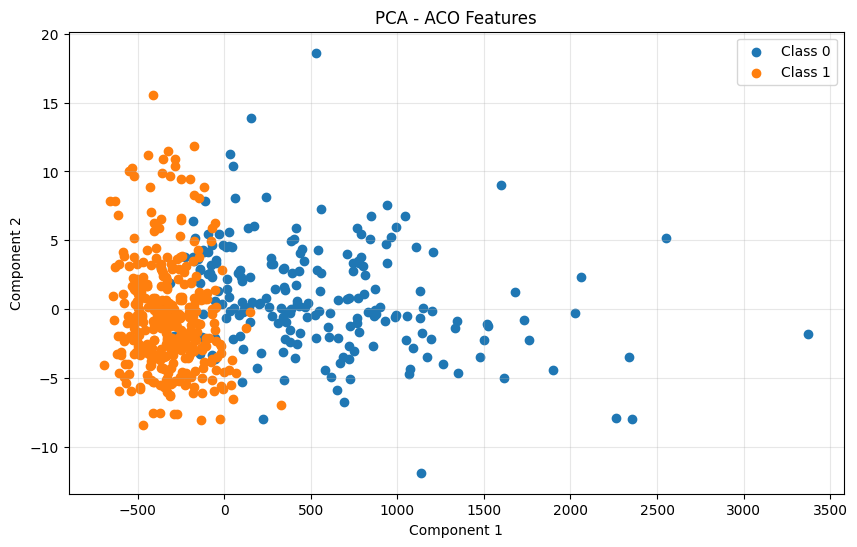

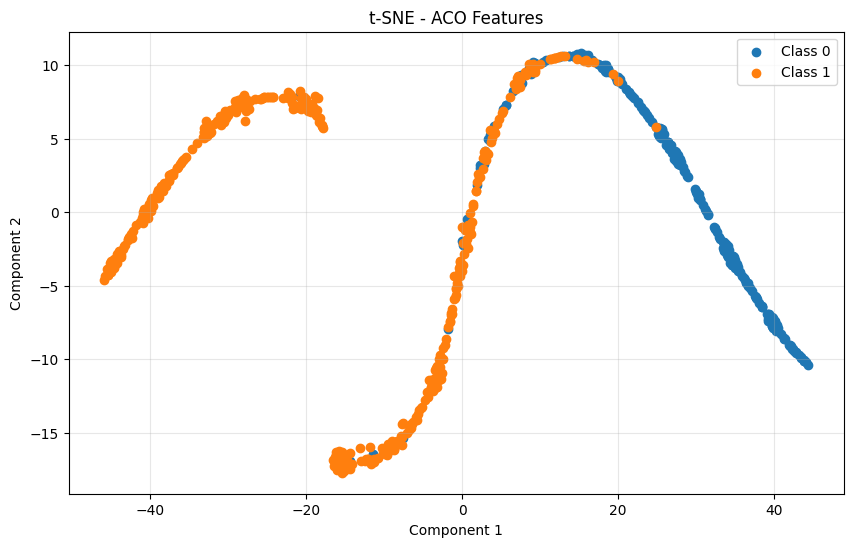

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
import json
import os
from datetime import datetime


class ACOFeatureSelector:
    def __init__(self, config=None):
        # Default configuration
        self.default_config = {
            "n_ants": 10,
            "n_iterations": 10,
            "alpha": 1,
            "beta": 2,
            "evaporation_rate": 0.5,
            "q": 100,
            "top_k": 5,
            "runs_per_setting": 5,
            "param_grid": {
                "alpha": [1, 2],
                "beta": [2, 3],
                "evaporation_rate": [0.3, 0.5],
            },
            "log_dir": "aco_logs"
        }

        # Merge custom config
        self.config = self.default_config
        if config:
            self.config.update(config)

        os.makedirs(self.config["log_dir"], exist_ok=True)
        self.seed_log = []

    def load_data(self):
        data = load_breast_cancer()
        self.X = data.data
        self.y = data.target
        self.n_features = self.X.shape[1]

    def fitness(self, path, top_k):
        selected_features = self.X[:, path[:top_k]]
        clf = RandomForestClassifier(random_state=42)
        scores = cross_val_score(clf, selected_features, self.y, cv=3)
        return 1 - scores.mean()

    def select_next_node(self, path, current_node, dist_matrix, pheromone_matrix, alpha, beta):
        probabilities = []
        pheromones = pheromone_matrix[current_node]
        for i in range(self.n_features):
            if i not in path:
                pheromone = pheromones[i] ** alpha
                distance = dist_matrix[current_node][i] ** beta
                probabilities.append((pheromone / distance) if distance > 0 else 0)
            else:
                probabilities.append(0)
        probabilities = np.array(probabilities)
        probabilities = probabilities / probabilities.sum()
        return np.random.choice(range(self.n_features), p=probabilities)

    def run_aco_once(self, seed, alpha, beta, evaporation_rate, q, top_k):
        np.random.seed(seed)
        random.seed(seed)

        pheromone_matrix = np.ones((self.n_features, self.n_features))
        dist_matrix = pairwise_distances(self.X)
        best_path = None
        best_fitness = float("inf")

        for iteration in range(self.config["n_iterations"]):
            ants = []
            for _ in range(self.config["n_ants"]):
                path = []
                current_node = random.randint(0, self.n_features - 1)
                path.append(current_node)

                while len(path) < self.n_features:
                    next_node = self.select_next_node(path, current_node, dist_matrix, pheromone_matrix, alpha, beta)
                    path.append(next_node)
                    current_node = next_node

                fitness_value = self.fitness(path, top_k)
                ants.append((path, fitness_value))

                if fitness_value < best_fitness:
                    best_fitness = fitness_value
                    best_path = path

            pheromone_matrix *= (1 - evaporation_rate)
            print(f"Iteration {iteration + 1}/{self.config['n_iterations']} completed.")

            for path, fit in ants:
                for i in range(len(path) - 1):
                    pheromone_matrix[path[i]][path[i + 1]] += q / fit
            print(f"Iteration {iteration + 1}/{self.config['n_iterations']} completed. Best Fitness: {best_fitness:.4f}")

        return best_path[:top_k], 1 - best_fitness  # Return selected features & accuracy

    def run_experiments(self):
        self.load_data()
        results = []
        seeds_used = []

        grid = self.config["param_grid"]
        experiment_id = datetime.now().strftime("%Y%m%d_%H%M%S")

        for alpha in grid["alpha"]:
            for beta in grid["beta"]:
                for evap in grid["evaporation_rate"]:
                    setting_result = []
                    for run_id in range(self.config["runs_per_setting"]):
                        seed = np.random.randint(0, 10000)
                        seeds_used.append(seed)
                        selected, acc = self.run_aco_once(
                            seed=seed,
                            alpha=alpha,
                            beta=beta,
                            evaporation_rate=evap,
                            q=self.config["q"],
                            top_k=self.config["top_k"]
                        )
                        setting_result.append(acc)

                    avg_acc = np.mean(setting_result)
                    result = {
                        "alpha": alpha,
                        "beta": beta,
                        "evaporation_rate": evap,
                        "avg_accuracy": avg_acc,
                        "runs": setting_result
                    }
                    results.append(result)

        # Save log
        log_path = os.path.join(self.config["log_dir"], f"aco_results_{experiment_id}.json")
        with open(log_path, "w") as f:
            json.dump({
                "results": results,
                "seeds": seeds_used,
                "config": self.config
            }, f, indent=4)

        print(f"\n Results logged to: {log_path}")
        return results

    def visualize(self, data, title):
        plt.figure(figsize=(10, 6))
        for label in np.unique(self.y):
            plt.scatter(data[self.y == label, 0], data[self.y == label, 1], label=f"Class {label}")
        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    def compare_accuracy(self, selected_features):
        clf = RandomForestClassifier(random_state=42)
        baseline = cross_val_score(clf, self.X, self.y, cv=3).mean()
        reduced = cross_val_score(clf, self.X[:, selected_features], self.y, cv=3).mean()
        print(f"\n Accuracy with All Features: {baseline:.4f}")
        print(f" Accuracy with ACO-selected Features: {reduced:.4f}")

    def fine_tune_classifier(self, selected_features):
        print("\n🔍 Tuning Random Forest...")
        X_reduced = self.X[:, selected_features]
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 5, 10, 20]
        }
        clf = RandomForestClassifier(random_state=42)
        grid = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy')
        grid.fit(X_reduced, self.y)
        print(f"Best Params: {grid.best_params_}")
        print(f"Best Accuracy: {grid.best_score_:.4f}")

    def apply_pca_tsne(self, selected_features):
        print("\n Visualizing with PCA and t-SNE...")
        self.visualize(PCA(n_components=2).fit_transform(self.X), "PCA - All Features")
        self.visualize(TSNE(n_components=2, random_state=42).fit_transform(self.X), "t-SNE - All Features")
        reduced_X = self.X[:, selected_features]
        self.visualize(PCA(n_components=2).fit_transform(reduced_X), "PCA - ACO Features")
        self.visualize(TSNE(n_components=2, random_state=42).fit_transform(reduced_X), "t-SNE - ACO Features")

    def run_all(self):
        self.load_data()
        results = self.run_experiments()
        # Use the best run for visual analysis
        best_setting = max(results, key=lambda x: x["avg_accuracy"])
        print("\n Best Setting:", best_setting)
        # Use seed=42 for reproducibility of visuals
        selected_features, _ = self.run_aco_once(
            seed=42,
            alpha=best_setting["alpha"],
            beta=best_setting["beta"],
            evaporation_rate=best_setting["evaporation_rate"],
            q=self.config["q"],
            top_k=self.config["top_k"]
        )
        self.compare_accuracy(selected_features)
        self.fine_tune_classifier(selected_features)
        self.apply_pca_tsne(selected_features)


if __name__ == "__main__":
    aco = ACOFeatureSelector()
    aco.run_all()
